# Implementação Algoritmo de Shor

> Este notebook foi adaptado do material oficial da IBM para codificação com Qiskit. O original pode ser visualizado em [[1]](https://quantum.cloud.ibm.com/docs/en/tutorials/shors-algorithm) 

## O algoritmo

O Algoritmo de Shor é um algoritmo quântico desenvolvido por Peter Shor, em 1994 para a fatoração de números inteiros. Para além de seu valor técnico, o algoritmo foi um marco na história da computação quântica ao apresentar um algoritmo mais eficiente que suas contrapartes clássica e com impacto significativo na realidade.

A capacidade desse algoritmo em fatorar números primos é a base para o risco criptográfico que ele representa, visto que é a dificuldade dessa tarefa para algoritmos clássicos que sustenta a segurança de algoritmos de criptografia como RSA. Para além disso, o próprio Peter Shor desenvolveu um algoritmo para o cálculo do logaritmo discreto, base de sistemas como o de Troca de Chaves Diffie–Hellman e sua variante de Curva Elíptica. 

### Estratégia geral 

O Algoritmo de Shor transforma o problema de fatorar um inteiro $N$ em um problema de *encontrar a ordem* (o período) de uma função modular, que pode ser resolvido eficientemente com um sub-rotina quântica. Em seguida usa passos clássicos simples (gcd, potenciação modular) para extrair fatores a partir desse período.

Em linhas gerais, o algoritmo começa com a escolha aleatória de um elemento $a$ que é menor que $N$ e maior que $1$, avaliando se o máximo divisor comum entre $a$ e $N$ é diferente de 1. Se o resultado anterior for diferente de 1, significa que um fator já foi encontrado (assumindo que o número $N$ é formado pelo produto de dois números primos).

Porém, caso esse valor seja igual a 1, então uma função $f(x)=a^x \bmod N$ é definida (entenda, neste caso, a operação de $mod$ como o resto da divisão). Visto que essa função é periódica (uma maneira de visualizar isso é fixando $a$. Como $N$ já é fixo, $f(x)$ pode varia entre valores de $0$ à $N-1$, fazendo com que tenhamos um comportamento cíclico), existe um menor inteiro positivo $r$ para o qual $a^r \equiv 1 \pmod N$. Esse $r$ é a ordem de $a$ módulo $N$. Tendo $r$, se $r$ for par e $a^{r/2} \not\equiv -1 \pmod N$, então $\gcd(a^{r/2} \pm 1, N)$ fornece um divisor não-trivial de $N$.

Para chegar ao valor $r$, usa-se a Transformada de Fourier Quântica (ou Transformada Quântica de Fourier) com o objetivo de obter informações do período da função.

### Exemplo numérico

Para $N=15$, se escolhermos $a=2$. A sequência $2^x \bmod 15$ é: 2,4,8,1,... então o período $r=4$.

Como $r$ é par e $2^{r/2}=2^2=4\not\equiv -1\pmod{15}$, calculamos:

$\gcd(4-1,15)=\gcd(3,15)=3$ e $\gcd(4+1,15)=\gcd(5,15)=5$. Achamos os fatores 3 e 5.

## Implementação

### Setup



In [73]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime

In [2]:
import numpy as np
import pandas as pd
from fractions import Fraction
from math import floor, gcd, log

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

### Funções de aritmética modular

In [3]:
def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

In [4]:
M2 = M2mod15()

circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)

# Tire o comentário a seguir caso queira visualizar este trecho do circuito
# circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [5]:
def controlled_M2mod15():
    """
    Controlled M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

In [6]:
controlled_M2 = controlled_M2mod15()

circ = QuantumCircuit(5)
circ.compose(controlled_M2, inplace=True)

# Tire o comentário a seguir caso queira visualizar este trecho do circuito
# circ.decompose(reps=1).draw(output="mpl", fold=-1)

In [7]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

In [8]:
def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

In [9]:
# Get the M4 operator
M4 = M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)

# Tire o comentário a seguir caso queira visualizar este trecho do circuito
# circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [10]:
def controlled_M4mod15():
    """
    Controlled M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

In [11]:
# Get the controlled-M4 operator
controlled_M4 = controlled_M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M4, inplace=True)

# Tire o comentário a seguir caso queira visualizar este trecho do circuito
# circ.decompose(reps=1).draw(output="mpl", fold=-1)

In [12]:
def mod_mult_gate(b, N):
    """
    Modular multiplication gate from permutation matrix.
    """
    if gcd(b, N) > 1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N - 1, 2)) + 1
        U = np.full((2**n, 2**n), 0)
        for x in range(N):
            U[b * x % N][x] = 1
        for x in range(N, 2**n):
            U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

In [13]:
# Let's build M2 using the permutation matrix definition
M2_other = mod_mult_gate(2, 15)

# Add it to a circuit
circ = QuantumCircuit(4)
circ.compose(M2_other, inplace=True)
circ = circ.decompose()

# Transpile the circuit and get the depth
coupling_map = CouplingMap.from_line(4)
pm = generate_preset_pass_manager(coupling_map=coupling_map)
transpiled_circ = pm.run(circ)

### Montagem circuito principal

O circuito principal inclui as portas que controle que irão transferir a informação de fase, juntamente com a implementação da QFT (usou-se implementação própria do Qiskit)


In [14]:
# Parâmetros
# Order finding problem, N = 15 com a = 2
N = 15
a = 2

# Número de qubits
num_target = floor(log(N - 1, 2)) + 1  # Para a exponenciação linear
num_control = 2 * num_target  # Para precisão na estimativa

# Lista de operadores M_b em ordem. Esses operadores estão relacionados à descrição e modelagem formal do problema, trecho omitido da explicação.
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]

# Inicialização do circuito
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)

# Inicialização do registrador alvo como |1>
circuit.x(num_control)

# Adiciona portas Hadamard e controles das portas de multiplicação
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator

/tmp/ipykernel_155187/3176096145.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)


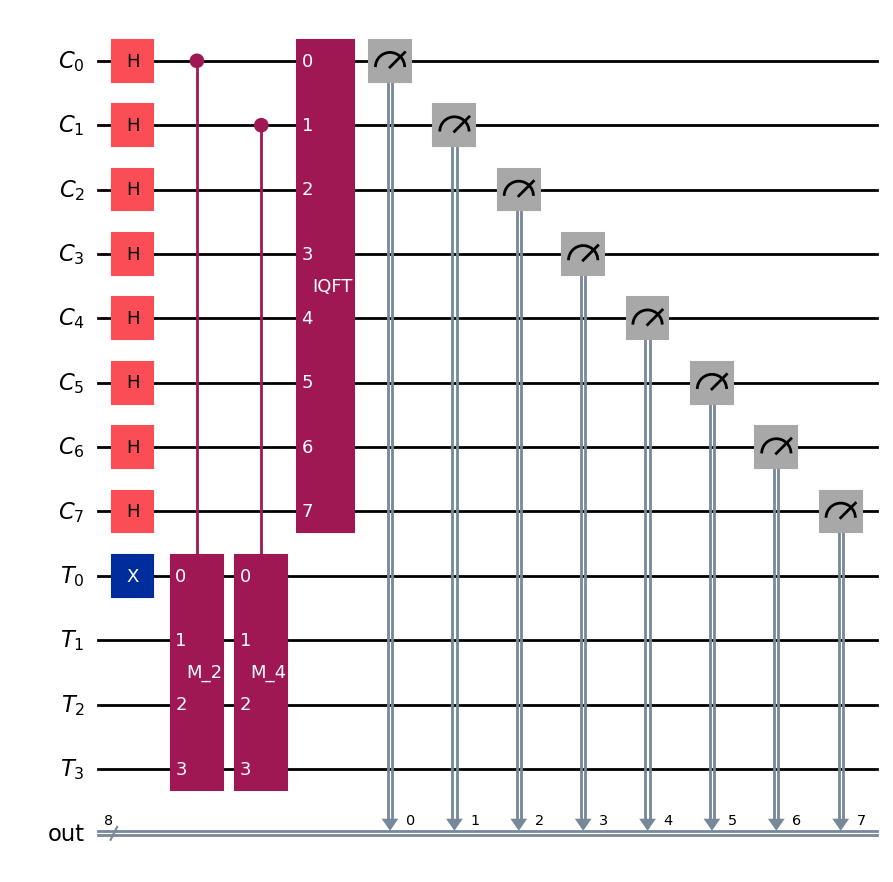

In [15]:
# Aplica a QFT inversa sobre os controles
circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)

# Mede os controles
circuit.measure(control, output)

circuit.draw("mpl", fold=-1)

2q-depth: 13
2q-size: 28
Contagem de operadores: OrderedDict({'cp': 28, 'ccx': 15, 'h': 14, 'measure': 8, 'x': 1})


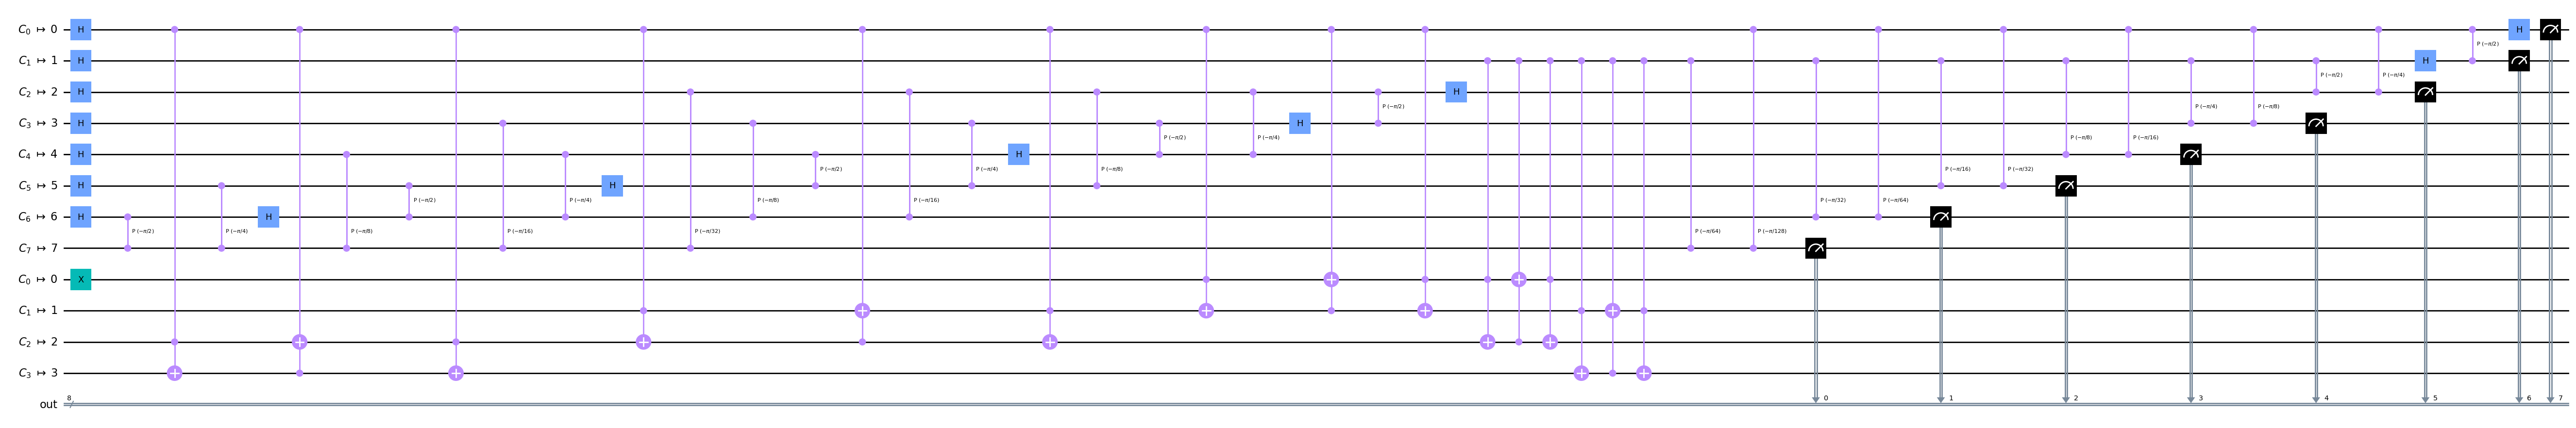

In [16]:
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

transpiled_circuit = pm.run(circuit)

print(
    f"2q-depth: {transpiled_circuit.depth(lambda x: x.operation.num_qubits==2)}"
)
print(
    f"2q-size: {transpiled_circuit.size(lambda x: x.operation.num_qubits==2)}"
)
print(f"Contagem de operadores: {transpiled_circuit.count_ops()}")
transpiled_circuit.draw(
    output="mpl", fold=-1, style="clifford", idle_wires=False
)

## Simulação



In [17]:
# Sampler primitive to obtain the probability distribution
sampler = Sampler(backend)

# Turn on dynamical decoupling with sequence XpXm
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
# Enable gate twirling
sampler.options.twirling.enable_gates = True

pub = transpiled_circuit
job = sampler.run([pub], shots=1024)

/home/inteli/miniconda3/envs/quantumSBSeg/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [18]:
result = job.result()[0]
counts = result.data["out"].get_counts()

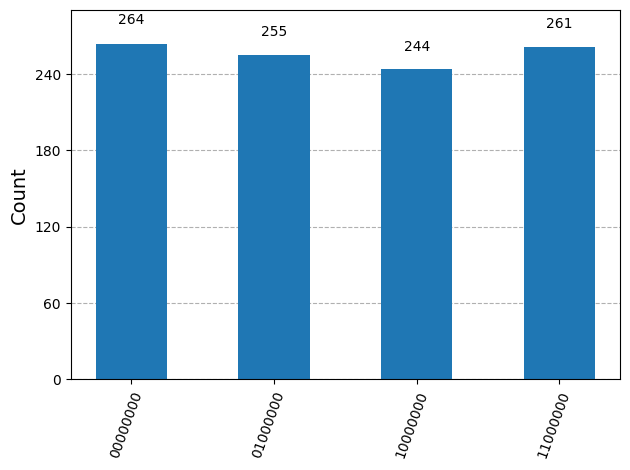

In [19]:
plot_histogram(counts)

In [20]:
# Dicionário com as bitstrings e contagem
counts_keep = {}
# Threshold to filter
threshold = np.max(list(counts.values())) / 2

for key, value in counts.items():
    if value > threshold:
        counts_keep[key] = value

print(counts_keep)

{'11000000': 261, '01000000': 255, '10000000': 244, '00000000': 264}


## Pós processamento clássico


In [21]:
# Parâmetros iniciais
a = 2
N = 15

FACTOR_FOUND = False
num_attempt = 0

while not FACTOR_FOUND:
    print(f"\nTentativa {num_attempt}:")
    # Here, we get the bitstring by iterating over outcomes
    # of a previous hardware run with multiple shots.
    # Instead, we can also perform a single-shot measurement
    # here in the loop.
    bitstring = list(counts_keep.keys())[num_attempt]
    num_attempt += 1
    # Find the phase from measurement
    decimal = int(bitstring, 2)
    phase = decimal / (2**num_control)  # phase = k / r
    print(f"Fase: theta = {phase}")

    # Guess the order from phase
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator  # order = r
    print(f"Ordem de {a} módulo {N} estimada: r = {r}")

    if phase != 0:
        # Guesses for factors are gcd(a^{r / 2} ± 1, 15)
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            d = gcd(x, N)
            if d > 1:
                FACTOR_FOUND = True
                print()
                print(f"*** Fator não-trivial encontrado: {x} ***")


Tentativa 0:
Fase: theta = 0.75
Ordem de 2 módulo 15 estimada: r = 4

*** Fator não-trivial encontrado: 3 ***
